# Goose Test Page (Page2: goose weight, energetics)

This is the second test page that is supposed to analyse the goose model data.<br>
First let us import the libraries and define the location of the data to analyse.

In [12]:
import pandas as pd
import datetime as dt
import numpy as np
#import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import configparser, os
#import re
#import pendulum

# this is definition whether we take into account timed values or not
# Is there a reason to use not timed values
is_timed = True

species_names = ["barnacle", "greylag", "pinkfoot"]
geese_foods = ['grain', 'grass', 'maize']
if is_timed==True:
    is_timed_str = '_timed'
else:
    is_timed_str = ''
    



data_dir =  "rundir/"#"~/CLionProjects/GooseTests/run-directory1/"
#source_dir = "~/CLionProjects/ALMaSS_all"
field_dir ="fielddir"#"~/CLionProjects/GooseTests/ALMaSS_inputs"
# let us read the config data, it will be useful afterwards
CONFIG_PATH=data_dir+'TIALMaSSConfig.cfg'
with open(os.path.expanduser(CONFIG_PATH), 'r') as f:
    config_string = '[dummy_section]\n' + f.read()
config = configparser.ConfigParser(strict=False)
config.read_string(config_string)

simulation_start_date = dt.date(2009, 1, 1)# we should check again that this is a right date, probably should be read from somewhere
simulation_start_date_ordinal=dt.date.toordinal(simulation_start_date)

my_dateparser=(lambda x: pd.to_datetime(x,unit='D', origin=simulation_start_date))

## Weight development

In [13]:

### Weight development
weight_data=pd.read_csv(data_dir+"GooseWeightStats.txt", sep='\t', header=0, dtype={'day': np.int16})
weight_data['daydate']=my_dateparser(weight_data['day'])
weight_data['week']=weight_data.daydate.dt.week
weight_data=weight_data[weight_data.iloc[:,5]>0 ]
field_data = pd.read_csv(field_dir+"/GooseManagement/Vejlerne/APIdata.txt", sep='\t', header=0, parse_dates=[0])
# we will change the field data into 2010-2011 seazon just to present them together nicely
field_data['weekdate']=np.array([i.strftime('%U') for i in field_data['Date']]).astype(int)
idx1=field_data['weekdate']>20
field_data.loc[idx1,'Date']=field_data[idx1]['Date'].apply(lambda dt:dt.replace(year=2010))
field_data.loc[np.logical_not(idx1),'Date']=field_data[np.logical_not(idx1)]['Date'].apply(lambda dt:dt.replace(year=2011))




Text(0.5, 0.98, 'Weight development')

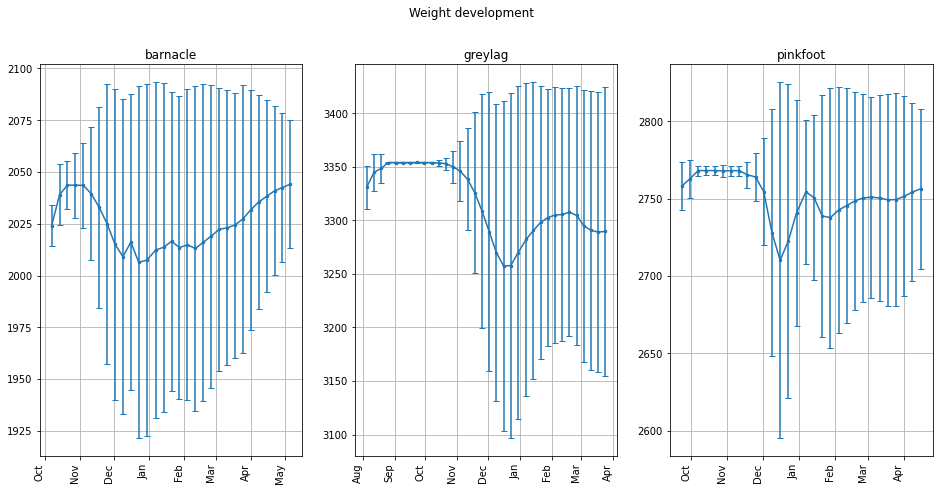

In [14]:

fig9, ax9 = plt.subplots(1,3,figsize=mpl.figure.figaspect(0.5)*2)

months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig9.autofmt_xdate(rotation='vertical')
for i in range(3):
    ax9[i].xaxis.set_major_formatter(myFmt)
    ax9[i].grid()           
    ax9[i].xaxis.set_minor_locator(months)
    ax9[i].xaxis_date()
    temp_data = weight_data[weight_data['species']==species_names[i]]
    line9=ax9[i].errorbar(temp_data['daydate'],temp_data['mean_weight'],temp_data['mean_weight_sd'], capsize=3, ms=5, marker=".")
    ax9[i].set_title(species_names[i])

fig9.suptitle('Weight development')

Text(0.5, 0.98, 'Pinkfoot weights during the season')

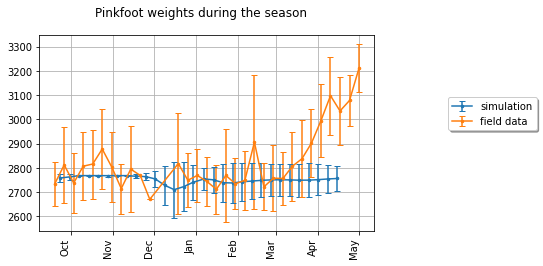

In [15]:

# Let us compare the field data and the simulation
fig10, ax10 = plt.subplots()
months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig10.autofmt_xdate(rotation='vertical')
ax10.xaxis.set_major_formatter(myFmt)
pinkfoot_simdata = weight_data[weight_data['species']=='pinkfoot']
# silly trick: first encode the week
field_data['weekdate1']=field_data['Date'].dt.strftime('%Y-W%U')
# now decode it into the date, while installing the day of the week as sunday
field_data['weekdate2']=[dt.datetime.strptime(i+'-0', '%Y-W%U-%w') for i in field_data['weekdate1']]

field_agg=field_data.groupby('weekdate2').agg(weight_mean=('Weight', np.mean), weight_std=('Weight',np.std))



line10=ax10.errorbar(pinkfoot_simdata['daydate'],pinkfoot_simdata['mean_weight'],temp_data['mean_weight_sd'], capsize=3, ms=5, marker=".")
line11=ax10.errorbar(field_agg.index,field_agg['weight_mean'],field_agg['weight_std'], capsize=3, ms=5, marker=".")
ax10.legend(handles=[line10,line11], labels=['simulation', 'field data'], fancybox=True, shadow=True, loc='center right',bbox_to_anchor=(1.5, 0.60))
ax10.grid()
fig10.suptitle('Pinkfoot weights during the season')

<i>The simulation data is obviously has too low variability. This is may be related to:
* the incorrect calculation:
    + The families regaraded in the mean calculations as a one entity with no inner variability
    + Also the way the family members influence the standard deviation is disregarded
* the incorrect assumptions (by design): all the animals come to Denmark with the same weight<br>
_I will try to patch these issues_
However in addition to the problem of variability the field data shows that the weight increases in pinkfoots from March to May (~15% increase). In our simulation this behaviour can be observed in barnacles but in pinkfoot the weight does not increase in these months, and when it increases in the late winter, the increase is much smaller.
</i>
*[Tweak the variation (Std of error) of goose size to correspond to the real data (at least not in the families but for lone individuals).](https://gitlab.com/ChrisTopping/ALMaSS_all/-/issues/69) *

## Goose energetics

In [16]:
energetics_data=pd.read_csv(data_dir+"GooseEnergeticsData.txt", sep='\t', header=0)
energetics_data['daydate']=my_dateparser(energetics_data['day'])

### Distance flown
Let's investigate the flown distance first. We will plot daily reported flown distance.

Text(0.5, 0.98, 'Daily flight distance')

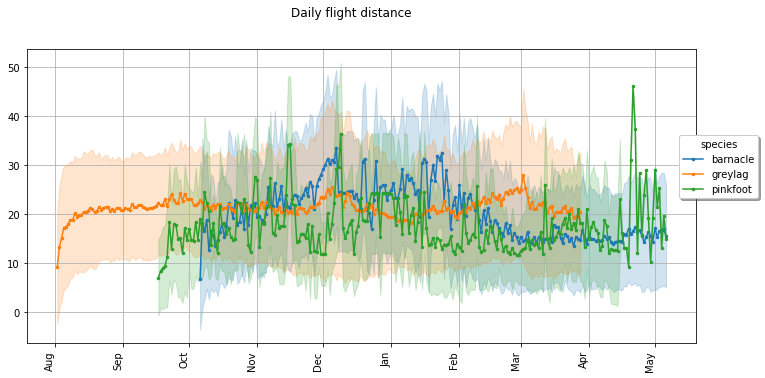

In [17]:
fig11, ax11 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*1.5)
months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
# plt.sca()
fig11.autofmt_xdate(rotation='vertical')
ax11.xaxis.set_major_formatter(myFmt)
line12=[None]*3
line12_sh=[None]*3
for i in range(3):
    temp = energetics_data[energetics_data.species.eq(species_names[i]) & (energetics_data.flight_distance>0)]['flight_distance']/1000
    temp_sd = energetics_data[energetics_data.species.eq(species_names[i]) & (energetics_data.flight_distance>0)]['flight_distance_sd']/1000
    times = energetics_data[energetics_data.species.eq(species_names[i]) & (energetics_data.flight_distance>0)]['daydate']
    line12[i],=ax11.plot(times,temp, ms=5, marker=".")
    line12_sh[i]=ax11.fill_between(times, temp-temp_sd, temp+ temp_sd ,alpha=0.2,color=line12[i]._color)
ax11.legend(handles=line12, labels=species_names, fancybox=True, shadow=True, title='species', loc='center right',bbox_to_anchor=(1.1, 0.60))
ax11.grid()
fig11.suptitle('Daily flight distance')

*Also here it seems like the variance is suspiciously small. Basically the standard error is around 100m, meaning that while geese travel for around 20km per day, they travel it +/-100 meters. One should check whether this is caused by the bug in the reporting (similarly to one I found in weights reporting) or in basic behavioural model of the animal.*
*The variation in flight distance is very small. [Suspect a bug.](https://gitlab.com/ChrisTopping/ALMaSS_all/-/issues/70)*

### Foraging time (daily)

Text(0.5, 0.98, 'Daily foraging time')

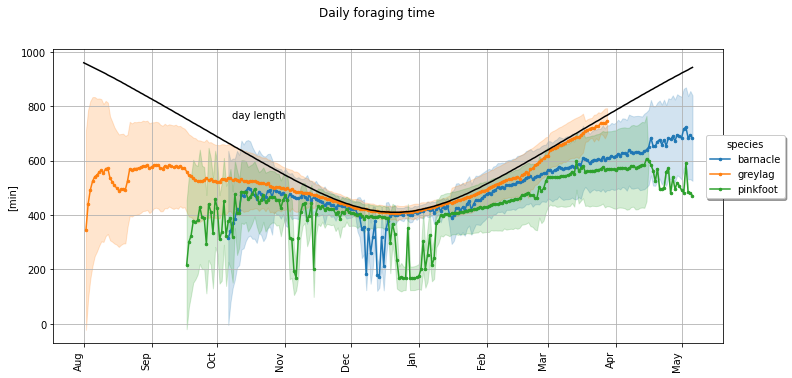

In [18]:
# Foraging time
fig12, ax12 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*1.5)
months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
fig12.autofmt_xdate(rotation='vertical')
ax12.xaxis.set_major_formatter(myFmt)
line13=[None]*3
line13_sh=[None]*3

for i in range(3):
    temp = energetics_data[energetics_data.species.eq(species_names[i]) & (energetics_data.flight_distance>0)]['foraging_time']
    temp_sd = energetics_data[energetics_data.species.eq(species_names[i]) & (energetics_data.flight_distance>0)]['foraging_time_sd']
    times = energetics_data[energetics_data.species.eq(species_names[i]) & (energetics_data.flight_distance>0)]['daydate']
    line13[i],=ax12.plot(times,temp, ms=5, marker=".")
    line13_sh[i]=ax12.fill_between(times, temp-temp_sd, temp+ temp_sd ,alpha=0.2,color=line12[i]._color)

ax12.plot(energetics_data.daydate,energetics_data.day_length, color='black')
ax12.annotate('day length', (mdates.date2num(dt.datetime(2010, 10, 1)), 700), xytext=(15, 15), textcoords='offset points')
ax12.legend(handles=line13, labels=species_names, fancybox=True, shadow=True, title='species', loc='center right',bbox_to_anchor=(1.1, 0.60))
ax12.set_ylabel('[min]')
ax12.grid()
fig12.suptitle('Daily foraging time')


*The fact that the geese do not forage the whole day may mean that they full (time to hit full appetite) is reached. There are several possible problems with it: [they may not fly enough because the hunting bangs happen to rarely and there is no random bangs](https://gitlab.com/ChrisTopping/ALMaSS_all/-/issues/71) and [their energy ballance is off](https://gitlab.com/ChrisTopping/ALMaSS_all/-/issues/72)*

### Daily energy balance

Text(0.5, 0.98, 'Daily energy balance ')

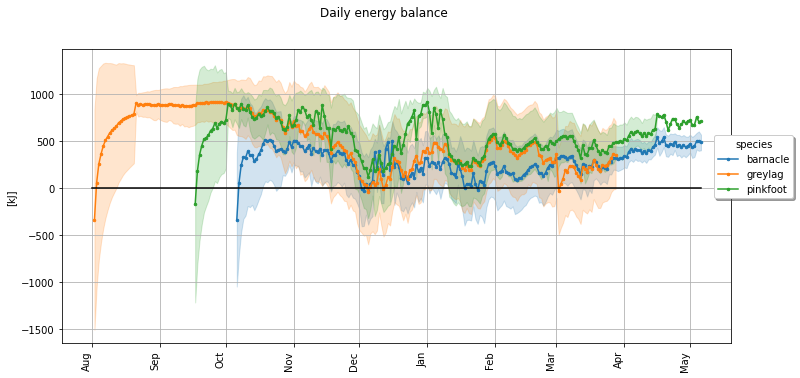

In [19]:
fig13, ax13 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*1.5)
months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
fig13.autofmt_xdate(rotation='vertical')
ax13.xaxis.set_major_formatter(myFmt)
line14=[None]*3
line14_sh=[None]*3

for i in range(3):
    temp = energetics_data[(energetics_data.species.eq(species_names[i])) & (energetics_data.flight_distance>0)]['daily_energy_balance']
    temp_sd = energetics_data[(energetics_data.species.eq(species_names[i])) & (energetics_data.flight_distance>0)]['daily_energy_balance_sd']
    times = energetics_data[(energetics_data.species.eq(species_names[i])) & (energetics_data.flight_distance>0)]['daydate']
    line14[i],=ax13.plot(times,temp, ms=5, marker=".")
    line14_sh[i]=ax13.fill_between(times, temp-temp_sd, temp+ temp_sd ,alpha=0.2,color=line12[i]._color)
    
start = energetics_data.daydate.min()
end = energetics_data.daydate.max()
t = np.linspace(start.value, end.value, 100)
t = pd.to_datetime(t)
ax13.plot(t,np.zeros(len(t)), color='black')
ax13.grid()
ax13.legend(handles=line14, labels=species_names, fancybox=True, shadow=True, title='species', loc='center right',bbox_to_anchor=(1.1, 0.60))
ax13.set_ylabel('[kJ]')
fig13.suptitle('Daily energy balance ')

*This graph shows how much is a daily energy surplus. One can see that the energy is gained throughout the season. In the colder months the surplus is small, however it should not cause the average weight to drop. It also cannot be caused by the new \'lean\' geese entering the simulation, since the numbers drop at that time. __[Under the investigation. Checking how the energy ballance translates into weight. Checking for inconsistencies. Also energy surplus variation is small, which is suspicious.](https://gitlab.com/ChrisTopping/ALMaSS_all/-/issues/72)__ *

### Number of foraging locations

Text(0.5, 0.98, 'Daily number of forage locations')

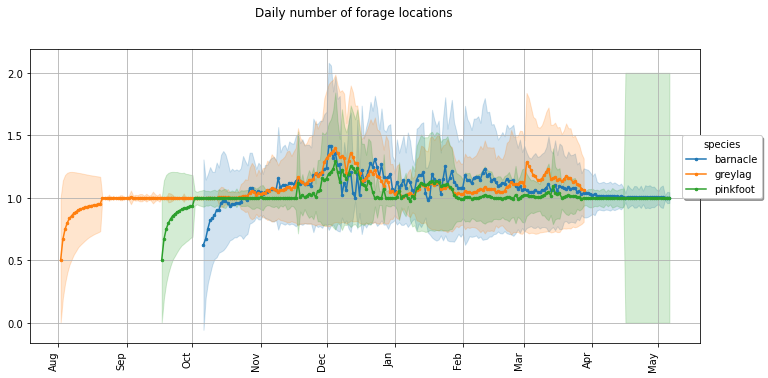

In [20]:
locations_stats_data=pd.read_csv(data_dir+"GooseIndLocCountStats.txt", sep='\t', header=0)
locations_stats_data['daydate']=my_dateparser(locations_stats_data['day'])

fig14, ax14 = plt.subplots(figsize=mpl.figure.figaspect(0.5)*1.5)
months = mdates.MonthLocator()
myFmt = mdates.DateFormatter('%b')
fig14.autofmt_xdate(rotation='vertical')
ax14.xaxis.set_major_formatter(myFmt)
ax14.grid()
line15=[None]*3
line15_sh=[None]*3

for i in range(3):
    temp = locations_stats_data[(locations_stats_data.species.eq(species_names[i])) & (locations_stats_data.n_forage_locs>0)]['n_forage_locs']
    temp_sd = locations_stats_data[(locations_stats_data.species.eq(species_names[i])) & (locations_stats_data.n_forage_locs>0)]['n_forage_locs_sd']
    times = locations_stats_data[(locations_stats_data.species.eq(species_names[i])) & (locations_stats_data.n_forage_locs>0)]['daydate']
    line15[i],=ax14.plot(times,temp, ms=5, marker=".")
    line15_sh[i]=ax14.fill_between(times, temp-temp_sd, temp+ temp_sd ,alpha=0.2,color=line12[i]._color)



ax14.legend(handles=line15, labels=species_names, fancybox=True, shadow=True, title='species', loc='center right',bbox_to_anchor=(1.1, 0.60))
ax14.set_ylabel('')
fig14.suptitle('Daily number of forage locations')

*This may be related to the [issue](https://gitlab.com/ChrisTopping/ALMaSS_all/-/issues/71) already opened*